In [28]:
from scipy import io
import pandas as pd
import umap # First time you run this enter pip install umap-learn in your Anaconda Prompt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

norm = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx'
c = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_cols'
r = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_rows'
cols = []
rows = []
data = io.mmread(norm)
with open(c) as file:
    for line in file:
        cols.append(line.rstrip())

with open(r) as file:
    for line in file:
        rows.append(line.rstrip().split('\t')[0])
arr = data.toarray()

In [22]:
norm_counts = pd.DataFrame(arr, index = rows, columns = cols)
norm_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17432 entries, ENSDARG00000000001 to ENSDARG00000117200
Columns: 246 entries, SRR5810686 to SRR5810931
dtypes: float64(246)
memory usage: 32.8+ MB


In [44]:
""" This was run to convert the gene transcript IDs to KEGG IDs, since this process took so long
    the result was saved to a csv (geneID.csv) file and this code is not needed anymore. 

from Bio import Entrez
import time
import csv

Entrez.email = "mdpouls1@gmail.com"
geneIDs = []
rowsTest = rows[15000:]
i = 0
while i < len(rowsTest):
    for t in range(3):
        if i < len(rowsTest):
            handle = Entrez.esearch(db="gene", term=rowsTest[i])
            record = Entrez.read(handle)
            if len(record['IdList']) == 1:
                geneIDs.append(record['IdList'][0])
            elif len(record['IdList']) > 1:
                geneIDs.append('multiple')
            else:
                geneIDs.append('NaN')
            handle.close()
            i += 1
    time.sleep(1)

with open('geneID.csv', 'a') as f:
    for gene in geneIDs:
        f.write('{},'.format(gene))
"""

In [23]:
ID_Data = pd.read_csv('geneID.csv')
IDs = ID_Data.columns

In [24]:
norm_counts['geneIDs'] = IDs
norm_counts.head(10)

,SRR5810686,SRR5810687,SRR5810688,SRR5810689,SRR5810690,SRR5810691,SRR5810692,SRR5810693,SRR5810694,SRR5810695,...,SRR5810923,SRR5810924,SRR5810925,SRR5810926,SRR5810927,SRR5810928,SRR5810929,SRR5810930,SRR5810931,geneIDs
ENSDARG00000000001,0.00000,0.000000,0.000000,0.0,3.021731,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,3123.14040,0.00000,0.000000,0.000000,368418
ENSDARG00000000018,0.00000,0.000000,0.000000,0.0,0.000000,88.754005,423.7024,0.000000,244.993700,480.814330,...,0.0,0.0,53.839350,85.774960,0.0,0.00000,0.00000,0.000000,612.748800,64604
ENSDARG00000000019,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,211.69173,0.00000,168.698530,0.000000,368425
ENSDARG00000000068,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.860707,0.000000,327272
ENSDARG00000000069,108.11358,477.412380,0.000000,0.0,342.167420,399.198760,169.6043,127.601425,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.000000,1.214048,58093
ENSDARG00000000086,0.00000,0.000000,21.663803,0.0,0.000000,0.000000,0.0000,148.062700,9.043391,2.054422,...,0.0,0.0,21.067574,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,368504
ENSDARG00000000103,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,145.516390,0.000000,...,0.0,0.0,7.802805,75.422806,0.0,0.00000,164.37566,0.000000,65.006750,555454
ENSDARG00000000142,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,368645
ENSDARG00000000151,0.00000,23.762608,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,78.102020,4.292985,...,0.0,0.0,91.292816,125.704680,0.0,0.00000,0.00000,82.627850,3.611486,30670
ENSDARG00000000183,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,407634


In [7]:
norm_counts.to_csv('norm_counts_data.csv')

In [8]:
with open('dataFile.txt', 'w') as file:
    file.write(' '.join(norm_counts['geneIDs'].to_list()))

In [9]:
annotationData = pd.read_table('uniprotData.tab')

In [10]:
annotationData = annotationData.rename(columns={"yourlist:M20210331A94466D2655679D1FD8953E075198DA81B3BDFU": "Ids"})

In [11]:
annotationData = annotationData.drop("yourlist:M20210331A94466D2655679D1FD8953E075198DA81B3B2BO", axis=1)

In [12]:
annotationData.head()

,Ids,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Pathway,Function [CC],Tissue specificity,Developmental stage,Gene ontology (biological process),Gene ontology IDs,Cross-reference (KEGG),Annotation,Keywords
0,368418,Q90X48,S35A5_DANRE,reviewed,Probable UDP-sugar transporter protein SLC35A5...,slc35a5 si:bZ20I5.1 zgc:66231,Danio rerio (Zebrafish) (Brachydanio rerio),440,NaN,NaN,NaN,NaN,carbohydrate transport [GO:0008643],GO:0005794; GO:0008643; GO:0015165; GO:0030173,dre:368418;,2 out of 5,Glycoprotein;Membrane;Reference proteome;Sugar...
1,64604,Q90X44,NRF1_DANRE,reviewed,Nuclear respiratory factor 1 (Nrf-1) (Not real...,nrf1,Danio rerio (Zebrafish) (Brachydanio rerio),514,NaN,FUNCTION: Probable transcription factor that i...,NaN,DEVELOPMENTAL STAGE: Expressed in the developi...,cellular response to cold [GO:0070417]; multic...,GO:0000978; GO:0001046; GO:0001895; GO:0003407...,dre:64604;,5 out of 5,Activator;Alternative splicing;DNA-binding;Dev...
2,368425,Q7ZUF3,Q7ZUF3_DANRE,unreviewed,Ube2h protein (Ubiquitin-conjugating enzyme E2...,ube2h,Danio rerio (Zebrafish) (Brachydanio rerio),183,NaN,NaN,NaN,NaN,protein polyubiquitination [GO:0000209]; ubiqu...,GO:0000209; GO:0005524; GO:0005634; GO:0006511...,dre:368425;,2 out of 5,ATP-binding;Nucleotide-binding;Proteomics iden...
3,327272,Q6P2U7,Q6P2U7_DANRE,unreviewed,Na(+)/H(+) exchange regulatory cofactor NHE-RF,slc9a3r1a slc9a3r1 slc9a3r2,Danio rerio (Zebrafish) (Brachydanio rerio),384,NaN,FUNCTION: Scaffold protein that connects plasm...,NaN,NaN,otic vesicle development [GO:0071599]; protein...,GO:0001726; GO:0005102; GO:0005902; GO:0006612...,dre:327272;,4 out of 5,Cell projection;Membrane;Proteomics identifica...
4,327272,Q7ZVX1,Q7ZVX1_DANRE,unreviewed,Na(+)/H(+) exchange regulatory cofactor NHE-RF,slc9a3r1a slc9a3r1 slc9a3r2,Danio rerio (Zebrafish) (Brachydanio rerio),386,NaN,FUNCTION: Scaffold protein that connects plasm...,NaN,NaN,otic vesicle development [GO:0071599]; protein...,GO:0001726; GO:0005102; GO:0005902; GO:0006612...,dre:327272;,4 out of 5,Cell projection;Membrane


# UMAP Reduction:  
See the [UMAP Documentation page](https://umap-learn.readthedocs.io/en/latest/index.html) for details.
The module import cell at the top of this notebook has instructions for downloading the scikit learn plug-in for UMAP.  
**NOTE** This is a first pass - I'm not super sure it is ready to go.
**Next steps**  
**1** We need to cluster the data and assign tags to the data points  
**2** Add a third dimension to the UMAP reduction  
**3** Plot data in [altair](https://altair-viz.github.io/) to allow interaction  
**4** Add interaction steps, tags, whatever else we're doing!  

In [25]:
norm_counts_temp = norm_counts
norm_counts_temp = norm_counts_temp.drop(['geneIDs'],axis=1)
norm_vals = norm_counts_temp.values

In [29]:
norm_vals_scaled = StandardScaler().fit_transform(norm_vals)

In [31]:
UMAP_reducer = umap.UMAP()
reduced_genes = UMAP_reducer.fit_transform(norm_vals_scaled)
print('Done')

Done


Text(0.5, 1.0, 'UMAP projection of Zebra Fish genes, unclustered')

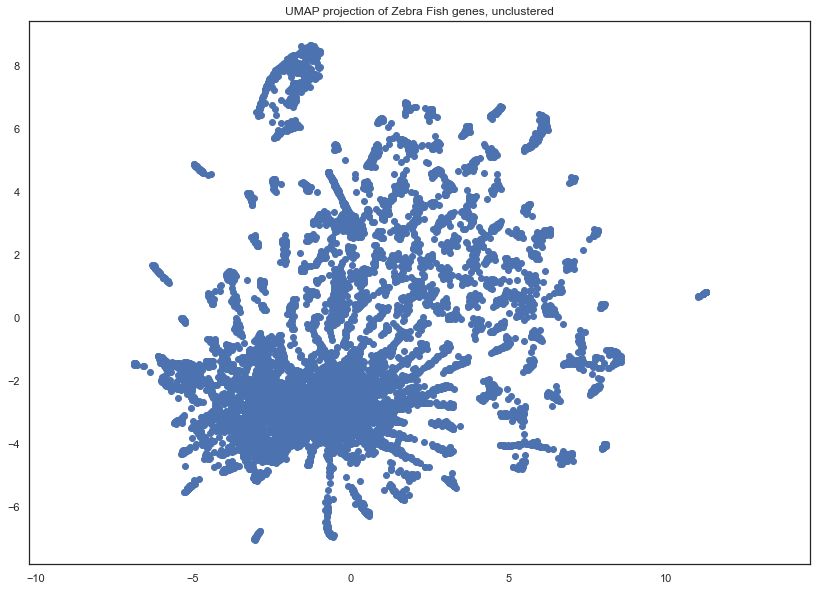

In [33]:
plt.scatter(reduced_genes[:,0],reduced_genes[:,1])
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')